# CLUSTERING DE ESTRUCTURAS 
la idea es hacer un cluster inicial para diferenciar cual es la estructura predicha donde convergen los 200 modelos generados

modelos deberian estar en la ubicacion

../models/

In [54]:
'''
#PLI
MBII-ethoxysanguinarine
MBIII-ethoxysanguinarine
MBIIyIII-ethoxysanguinarine

MBII-withaferin_A
MBIII-withaferin_A
MBIIyIII-withaferin_A

#PPI
P01106-Q9BZ95_MBII
P01106-Q9BZ95_MBIII
P01106-Q9BZ95_MBIIyIII
'''
state = 'P01106-Q9BZ95_MBIII' # modificar al usar
relative_path = f'../models/boltz_results_{state}/predictions/{state}/{state}_model_*.pdb'
relative_path

'../models/boltz_results_P01106-Q9BZ95_MBIII/predictions/P01106-Q9BZ95_MBIII/P01106-Q9BZ95_MBIII_model_*.pdb'

# load structures

In [55]:
def get_distances(traj):
    """Create a distance matrix"""
    import mdtraj as md
    from mdtraj.geometry.alignment import compute_average_structure
    import numpy as np
    traj_aligned = traj.superpose(traj[0], parallel=True)

    # matrix initialization
    distances = np.empty((traj.n_frames, traj.n_frames))
    # Pairwise RMSD calculation (matrix n²)
    for i in range(traj.n_frames):
        distances[i]=md.rmsd(traj_aligned,traj_aligned, frame=i)
    return distances

In [56]:
def TSNE_cluster(distances, min_cluster_size):
    """Create a TSNE cluster"""
    from sklearn.manifold import TSNE
    import hdbscan
    import matplotlib.pyplot as plt

    model = TSNE(n_components=2,init='random',verbose=2,perplexity=10,learning_rate='auto')
    data_tsne = model.fit_transform(distances)
    #plt.scatter(data_tsne.T[0],data_tsne.T[1],cmap="gnuplot")
    cluster = hdbscan.HDBSCAN(min_cluster_size)
    cluster.fit(data_tsne)
    plt.scatter(data_tsne.T[0],data_tsne.T[1],cmap="gnuplot",c=cluster.labels_)
    print(len(set(cluster.labels_)), set(cluster.labels_))
    return  data_tsne, cluster


In [67]:
def PCA_cluster(distances, min_cluster_size):
    from sklearn.decomposition import PCA, IncrementalPCA
    import hdbscan
    import matplotlib.pyplot as plt

    model = PCA(n_components=2,init='random',verbose=2,perplexity=10,learning_rate='auto')
    data_pca = model.fit_transform(distances)
    #plt.scatter(data_tsne.T[0],data_tsne.T[1],cmap="gnuplot")
    cluster = hdbscan.HDBSCAN(min_cluster_size)
    cluster.fit(data_pca)
    plt.scatter(data_pca.T[0],data_pca.T[1],cmap="gnuplot",c=cluster.labels_)
    print(len(set(cluster.labels_)), set(cluster.labels_))
    return  data_pca, cluster
    

In [74]:
import mdtraj as md
import glob

pdb_files = sorted(glob.glob(relative_path))
structures = [md.load(pdb, top=pdb) for pdb in pdb_files]
structures
# Stack into one trajectory
traj = structures[0].join(structures[1:])

In [75]:
traj

<mdtraj.Trajectory with 199 frames, 6061 atoms, 775 residues, without unitcells at 0x760758fe9510>

In [76]:
distances_traj = get_distances(traj)
print("Distances matrix ready!")

Distances matrix ready!


# clustering

✔ Matriz de distancias RMSD calculada
✔ Pairwise RMSD matrix computed!
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 199 samples in 0.000s...
[t-SNE] Computed neighbors for 199 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 199 / 199
[t-SNE] Mean sigma: 1.075399
[t-SNE] Computed conditional probabilities in 0.002s
[t-SNE] Iteration 50: error = 62.0134125, gradient norm = 0.3556273 (50 iterations in 0.016s)
[t-SNE] Iteration 100: error = 61.4109726, gradient norm = 0.3760070 (50 iterations in 0.018s)
[t-SNE] Iteration 150: error = 61.0381126, gradient norm = 0.3294395 (50 iterations in 0.018s)
[t-SNE] Iteration 200: error = 62.1612015, gradient norm = 0.3748778 (50 iterations in 0.022s)
[t-SNE] Iteration 250: error = 61.1410675, gradient norm = 0.3922359 (50 iterations in 0.019s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.141068
[t-SNE] Iteration 300: error = 0.7951291, gradient norm = 0.0078007 (50 iterations in 0.017s

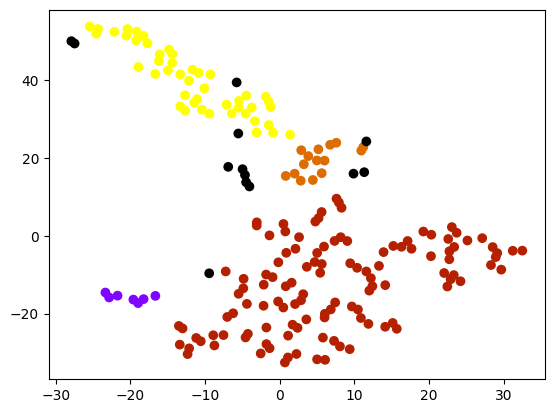

In [103]:
import mdtraj as md
import numpy as np
# -------------------------------------------------------------------
# 1) Carga (o asume que ya tienes) tu trayectoria mdtraj
#    Por ejemplo:
# traj = md.load('trajectory.xtc', top='topology.pdb')

# -------------------------------------------------------------------
# 2) Cálculo de la matriz de distancias RMSD pairwise
import numpy as np

dist_matrix = get_distances(traj)
print("✔ Matriz de distancias RMSD calculada")
print("✔ Pairwise RMSD matrix computed!")

# -------------------------------------------------------------------
# 3) Clustering con t-SNE
#    El segundo argumento (20) indica el tamaño mínimo de cluster que usas
data_tsne_traj,cluster_traj = TSNE_cluster(dist_matrix, min_cluster_size=4)
print("✔ Clustering ready!")

In [104]:
print(len(data_tsne_traj))

199


In [105]:
cluster_traj.labels_[:10]

array([ 3,  3,  1, -1,  3,  3,  3,  3,  3,  1])

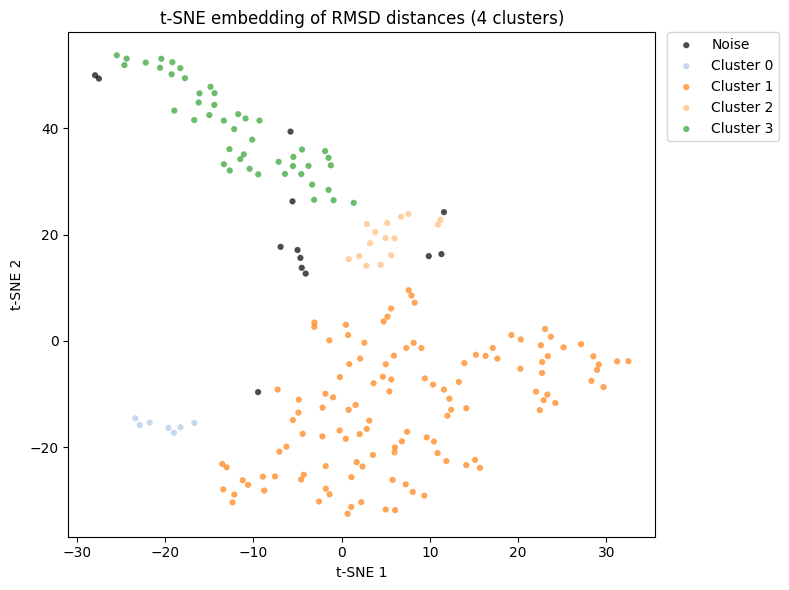

In [106]:
import numpy as np
import matplotlib.pyplot as plt

# Asumiendo que ya tienes estos objetos:
# data_tsne_traj: t-SNE 2D embedding (shape: [n_samples, 2])
# cluster_traj: output de HDBSCAN

labels = cluster_traj.labels_
unique_labels = np.unique(labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)  # sin contar ruido

# Cargar colormap
cmap = plt.get_cmap('tab20')

plt.figure(figsize=(8, 6))

for i, lbl in enumerate(unique_labels):
    idx = labels == lbl
    color = 'k' if lbl == -1 else cmap(i % 20)  # -1 es "ruido", lo pintamos de negro
    label_text = 'Noise' if lbl == -1 else f'Cluster {lbl}'
    
    plt.scatter(
        data_tsne_traj[idx, 0],
        data_tsne_traj[idx, 1],
        label=label_text,
        c=[color],
        s=20,
        alpha=0.7,
        edgecolors='none'
    )

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.title(f't-SNE embedding of RMSD distances ({n_clusters} clusters)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.tight_layout()
plt.show()


In [107]:
# creacion de un data frame 
import pandas as pd
import numpy as np

reference = traj[0]
rmsd = md.rmsd(traj, reference)

rmsd_angstrom = rmsd 

data_rmsds = pd.DataFrame([rmsd], index=["RMSD"])
data_rmsds = data_rmsds.T
data_rmsds["time"] = np.arange(len(data_rmsds["RMSD"]))
data_rmsds["time"]

0        0
1        1
2        2
3        3
4        4
      ... 
194    194
195    195
196    196
197    197
198    198
Name: time, Length: 199, dtype: int64

{'-1': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), '0': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0), '1': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), '2': (1.0, 0.7333333333333333, 0.47058823529411764, 1.0), '3': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0)}


/tmp/ipykernel_5491/165902305.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


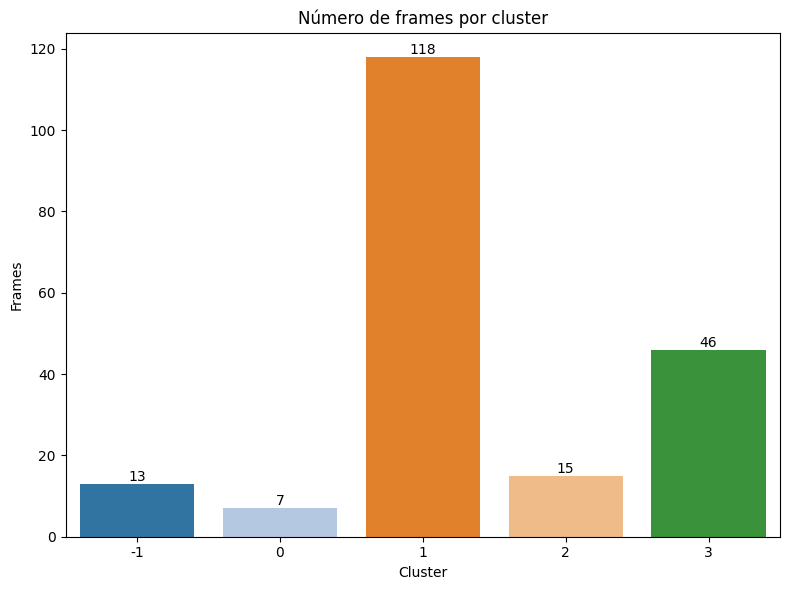

In [108]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Generar los datos del gráfico
labels, values = zip(*Counter(cluster_traj.labels_).items())
data8 = pd.DataFrame({'Groups': labels, 'Frames': values})

# 2) Definir la paleta tab20 de 20 colores
cmap = plt.get_cmap('tab20')
unique_labels = sorted(data8['Groups'].unique())
# Mapear cada etiqueta a un color distinto de tab20
palette = {str(lbl): cmap(i) for i, lbl in enumerate(unique_labels)}
print(palette)

# 3) Dibujar el barplot usando nuestra paleta
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    x="Groups",
    y="Frames",
    data=data8,
    palette=palette
)

# 4) (Opcional) Anotar cada barra con su valor
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{int(height)}',
        (p.get_x() + p.get_width() / 2, height),
        ha='center',
        va='bottom'
    )

plt.title('Número de frames por cluster')
plt.xlabel('Cluster')
plt.ylabel('Frames')
plt.tight_layout()
plt.show()

In [109]:
def plot_rmsd_with_average(data_rmsds, cluster_traj):
    # Calcular el valor promedio del RMSD
    average_rmsd = data_rmsds['RMSD'].mean()
    
    return average_rmsd

average_rmsd = plot_rmsd_with_average(data_rmsds, cluster_traj)

In [110]:
def get_centroid(traj, cluster, name, select=-1):
    """Centroid"""
    traj_aligned = traj.superpose(traj[0], parallel=True)

    from collections import defaultdict
    tally = defaultdict(list)

    # Agrupar los frames por cluster
    for i, label in enumerate(cluster.labels_):
        tally[label].append(i)

    labels = list(set(cluster.labels_))
    if select < 0:
        labels = [l for l in labels if l != -1]
    elif select >= 0:
        labels = [select]

    for lab in labels:
        global_indices = tally[lab]
        traj_cluster = traj_aligned.slice(global_indices)

        atom_indices = [a.index for a in traj_cluster.topology.atoms if a.element.symbol != 'H']
        distances = np.empty((traj_cluster.n_frames, traj_cluster.n_frames))
        for i in range(traj_cluster.n_frames):
            distances[i] = md.rmsd(traj_cluster, traj_cluster, i, atom_indices=atom_indices)

        beta = 1
        index = np.exp(-beta * distances / distances.std()).sum(axis=1).argmax()
        global_index = global_indices[index]

        centroid = traj[global_index]
        centroid.save_pdb(f"../frames/{name}_c{lab}_{global_index:03d}.pdb")

        return index, global_index, centroid

In [111]:
from collections import Counter
import pandas as pd
import seaborn as sns
import numpy as np
import mdtraj as md

name = state

def get_centroids_with_groups(traj, cluster_traj, name):
    """
    Obtiene los centroides de los clústeres y los asocia con sus respectivos grupos.
    Guarda la estructura representativa de cada centroide en un archivo PDB.
    """
    # Contar los frames por grupo, excluyendo el grupo -1
    labels, values = zip(*Counter(cluster_traj.labels_).items())
    data = pd.DataFrame({'Groups': labels, 'Frames': values})
    data = data[data['Groups'] != -1]  # Excluir el grupo -1
    
    # Ajustar la numeración de los grupos
    unique_groups = sorted(data['Groups'].unique())  # Obtener los grupos únicos sin -1
    mapping = {group: i for i, group in enumerate(unique_groups)}  # Numeración sin -1
    data['Mapped_Groups'] = data['Groups'].map(mapping)
    
    # Obtener los centroides correctamente
    results = []
    for group in data['Groups']:
        mapped_group = mapping[group]  # Obtener el grupo ajustado
        index, global_index, centroid = get_centroid(traj, cluster_traj, name, group)
        frame_index = global_index  # Este es el frame correcto del centroide
        
        # Guardar el frame seleccionado como archivo PDB
        output_pdb_file = f'../frames/{name}_frame_{frame_index}.pdb'
        centroid.save_pdb(output_pdb_file)
        
        # Imprimir en el formato correcto
        print(f"{index}, Estructura del frame {frame_index}, Grupo {mapped_group}, guardada en {output_pdb_file}")
        
        results.append((index, frame_index, mapped_group, output_pdb_file))
    
    return results, data  # Devolver también la tabla para futuras referencias

# Llamada a la función con la trayectoria y el clustering
centroid_results, data = get_centroids_with_groups(traj, cluster_traj, name)

# Ordenar los grupos por tamaño de mayor a menor
data_sorted = data.sort_values(by="Frames", ascending=False)

# Frames representativos en orden 
representative_frames = [
    frame[1] for group in data_sorted['Groups'] 
    for frame in centroid_results if frame[2] == group
]
representative_frames_str = ", ".join(map(str, representative_frames))  # Convertir a string ordenado


summary_table = pd.DataFrame({
    "Name": [name],
    "Frames": [traj.n_frames],
    "Residues": [traj.n_residues],
    "Atoms": [traj.n_atoms],
#    "Sequence": [sequence],
    "RMSD (nm)": [average_rmsd],
    "Conformations": [len(data)],
    "Representative Frames": [representative_frames_str]  
})


# Formato da tabla
styled_table = summary_table.style \
    .format(precision=3, thousands=".", decimal=",") \
    .format_index(str.upper, axis=1) \
    .set_properties(**{'text-align': 'left'}) \
    .set_table_styles([{
        'selector': 'th',
        'props': [('background-color', '#4CAF50'), ('color', 'white')]
    }])

styled_table

43, Estructura del frame 178, Grupo 3, guardada en ../frames/P01106-Q9BZ95_MBIII_frame_178.pdb
61, Estructura del frame 99, Grupo 1, guardada en ../frames/P01106-Q9BZ95_MBIII_frame_99.pdb
11, Estructura del frame 164, Grupo 2, guardada en ../frames/P01106-Q9BZ95_MBIII_frame_164.pdb
6, Estructura del frame 192, Grupo 0, guardada en ../frames/P01106-Q9BZ95_MBIII_frame_192.pdb


,NAME,FRAMES,RESIDUES,ATOMS,RMSD (NM),CONFORMATIONS,REPRESENTATIVE FRAMES
0,P01106-Q9BZ95_MBIII,199,775,6.061,"2,990",4,"99, 178, 164, 192"


In [112]:
representative_frames

[99, 178, 164, 192]

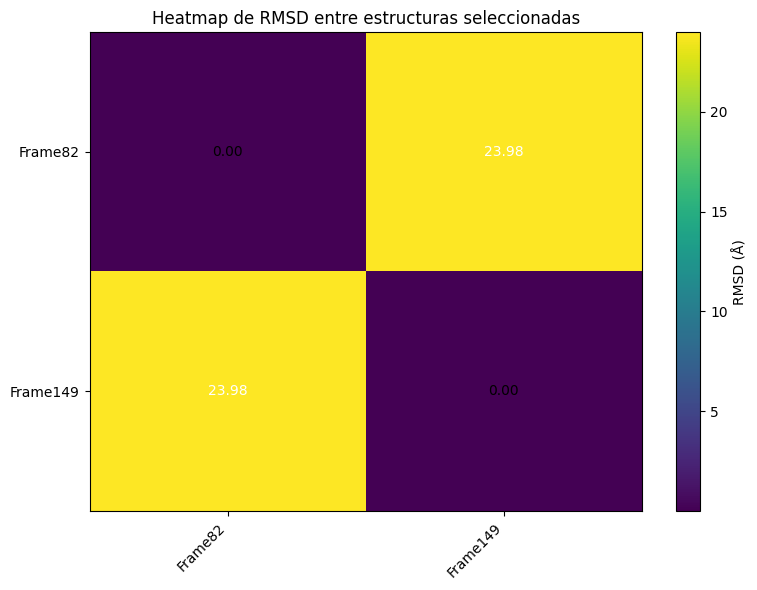

In [52]:
import MDAnalysis as mda
from MDAnalysis.analysis.rms import rmsd
import numpy as np
import matplotlib.pyplot as plt

frame_ids = representative_frames

# 1) Define tu lista de estructuras con etiqueta y ruta al PDB
structures = []

for frame in frame_ids:
    label = f"Frame{frame}"
    path = relative_path.replace("*", str(frame))  # Replace * with frame ID
    structures.append((label, path))


# 2) Carga coordenadas de backbone de cada estructura
coords = []
labels = []
for label, pdb_path in structures:
    u = mda.Universe(pdb_path)
    sel = u.select_atoms('protein and backbone')
    coords.append(sel.positions.copy())
    labels.append(label)

# 3) Calcula RMSD par a par (con superposición)
n = len(coords)
rmsd_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        rmsd_matrix[i, j] = rmsd(coords[i], coords[j], superposition=True)

# 4) Dibuja el heatmap con anotaciones
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(rmsd_matrix, interpolation='nearest', aspect='auto')
fig.colorbar(cax, label='RMSD (Å)')
ax.set_xticks(range(n))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_yticks(range(n))
ax.set_yticklabels(labels)

# 5) Anotar cada celda con el valor de RMSD
for i in range(n):
    for j in range(n):
        ax.text(j, i, f"{rmsd_matrix[i, j]:.2f}",
                ha='center', va='center', color='white' if rmsd_matrix[i,j]> (rmsd_matrix.max()/2) else 'black')

ax.set_title('Heatmap de RMSD entre estructuras seleccionadas')
plt.tight_layout()
plt.show()

# SOLO EN CASO DE QUE 2 CLUSTERES SEAN SIMILARES

### IPTM = Interface Predicted TM-score
Confidence in the interface between chains (i.e., between protein–protein or protein–ligand).

### Para PLI considerar usar ligand_IPTM
score calculated between protein and ligand.

In [64]:
import json

ligand_iptm_scores = {}

# If you have representative_frames_str as a string like "0, 38, 112", convert to list
if isinstance(representative_frames_str, str):
    representative_frames = [int(i.strip()) for i in representative_frames_str.split(",")]
else:
    representative_frames = representative_frames_str  # Already a list

for i in representative_frames:
    len_state = len(state)+12
    json_path = relative_path[:-len_state] + f'confidence_{state}_model_{i}.json'
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
            ligand_iptm = data.get("ligand_iptm", None)
            if ligand_iptm is not None:
                ligand_iptm_scores[i] = ligand_iptm
            else:
                print('error')
    except FileNotFoundError:
        print(f"File not found: {json_path}")


File not found: ../models/boltz_results_P01106-Q9BZ95_MBII/predictions/P01106-Q9BZ95_MBII/confidence_P01106-Q9BZ95_MBII_model_77.json
File not found: ../models/boltz_results_P01106-Q9BZ95_MBII/predictions/P01106-Q9BZ95_MBII/confidence_P01106-Q9BZ95_MBII_model_167.json
File not found: ../models/boltz_results_P01106-Q9BZ95_MBII/predictions/P01106-Q9BZ95_MBII/confidence_P01106-Q9BZ95_MBII_model_81.json
File not found: ../models/boltz_results_P01106-Q9BZ95_MBII/predictions/P01106-Q9BZ95_MBII/confidence_P01106-Q9BZ95_MBII_model_93.json
File not found: ../models/boltz_results_P01106-Q9BZ95_MBII/predictions/P01106-Q9BZ95_MBII/confidence_P01106-Q9BZ95_MBII_model_188.json
File not found: ../models/boltz_results_P01106-Q9BZ95_MBII/predictions/P01106-Q9BZ95_MBII/confidence_P01106-Q9BZ95_MBII_model_193.json
File not found: ../models/boltz_results_P01106-Q9BZ95_MBII/predictions/P01106-Q9BZ95_MBII/confidence_P01106-Q9BZ95_MBII_model_185.json


In [65]:
ligand_iptm_scores # highest is better

{8: 0.0, 1: 0.0}

### Para PPI considerar usar protein_IPTM
Interface confidence among protein chains only, excluding ligand.

In [66]:
import json

protein_iptm_scores = {}

# If you have representative_frames_str as a string like "0, 38, 112", convert to list
if isinstance(representative_frames_str, str):
    representative_frames = [int(i.strip()) for i in representative_frames_str.split(",")]
else:
    representative_frames = representative_frames_str  # Already a list

for i in representative_frames:
    len_state = len(state)+12
    json_path = relative_path[:-len_state] + f'confidence_{state}_model_{i}.json'
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
            protein_iptm = data.get("protein_iptm", None)
            if protein_iptm is not None:
                protein_iptm_scores[i] = protein_iptm
            else:
                print('error')
    except FileNotFoundError:
        print(f"File not found: {json_path}")

File not found: ../models/boltz_results_P01106-Q9BZ95_MBII/predictions/P01106-Q9BZ95_MBII/confidence_P01106-Q9BZ95_MBII_model_77.json
File not found: ../models/boltz_results_P01106-Q9BZ95_MBII/predictions/P01106-Q9BZ95_MBII/confidence_P01106-Q9BZ95_MBII_model_167.json
File not found: ../models/boltz_results_P01106-Q9BZ95_MBII/predictions/P01106-Q9BZ95_MBII/confidence_P01106-Q9BZ95_MBII_model_81.json
File not found: ../models/boltz_results_P01106-Q9BZ95_MBII/predictions/P01106-Q9BZ95_MBII/confidence_P01106-Q9BZ95_MBII_model_93.json
File not found: ../models/boltz_results_P01106-Q9BZ95_MBII/predictions/P01106-Q9BZ95_MBII/confidence_P01106-Q9BZ95_MBII_model_188.json
File not found: ../models/boltz_results_P01106-Q9BZ95_MBII/predictions/P01106-Q9BZ95_MBII/confidence_P01106-Q9BZ95_MBII_model_193.json
File not found: ../models/boltz_results_P01106-Q9BZ95_MBII/predictions/P01106-Q9BZ95_MBII/confidence_P01106-Q9BZ95_MBII_model_185.json


In [22]:
protein_iptm_scores # highest is better

{}